In [2]:
import pandas as pd
import numpy as np 
import os

import matplotlib.pyplot as plt
import matplotlib.cm 
import matplotlib.colors
from matplotlib.patches import Patch
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile
from selenobot.tools import BLAST
from selenobot.genes import Gene, Genome
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import re
from tqdm import tqdm 
from scipy.stats import mannwhitneyu

%load_ext autoreload
%autoreload 2

levels = ['phylum', 'class', 'order', 'family', 'genus', 'species']

# Generate a shell script to run on HPC to extract all genomes, proteins, and annotations from the complete GTDB directories to subset directories. 
# script_path = '../scripts/bash/move-gtdb-subset-files.sh'
# with open(script_path, 'w') as f:
#     for row in metadata_subset_df.itertuples():
#         cmd = f'mv ./gtdb_genomes/{row.genome_id}_genomic.fna.gz -t ./gtdb_subset_genomes/'
#         cmd = f'mv ./gtdb_proteins/{row.prefix}_{row.genome_id}_protein.faa -t ./gtdb_subset_proteins/'
#         cmd = f'mv ./gtdb_annotations_kegg/{row.prefix}_{row.genome_id}_protein.ko.tab -t ./gtdb_subset_annotations_kegg/'
#         f.write(cmd + '\n')

In [3]:
def load_metadata(path:str):
    '''Load in a GTDB metadata TSV file.'''
    metadata_df = pd.read_csv(path, delimiter='\t', low_memory=False, dtype={'partial':str})
    metadata_df = metadata_df.rename(columns={'accession':'genome_id'})
    metadata_df = metadata_df[metadata_df.gtdb_representative == 't'] # Get the representatives. 
    metadata_df['prefix'] = [genome_id[:2] for genome_id in metadata_df.genome_id] 
    metadata_df['genome_id'] = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in metadata_df.genome_id] # Remove the prefixes from the genome IDs.
    # Parse the taxonomy information... 
    for level in ['phylum', 'class', 'order', 'genus', 'species', 'family', 'domain']:
        metadata_df[level] = [re.search(f'{level[0]}__([^;]*)', taxonomy).group(1) for taxonomy in metadata_df.gtdb_taxonomy]
    return metadata_df

In [4]:
def get_subset(df:pd.DataFrame, level:str='phylum', model_organisms:list=[], missing_genome_ids:list=[]) -> pd.DataFrame:
    '''Subset the GTDB metadata by grabbing the taxon representative genome with the highest checkm_completeness.'''
    subset_df = [df[df.species.isin(model_organisms)]]
    df = df.sort_values('checkm_completeness', ascending=False)
    subset_df.append(df.drop_duplicates(subset=level, keep='first'))
    subset_df = pd.concat(subset_df)
    subset_df = subset_df[~subset_df.genome_id.isin(missing_genome_ids)]
    return subset_df

In [5]:
def fix_dtypes(df:pd.DataFrame):

    drop = ['checkm_strain_heterogeneity']
    drop += [col for col in df.columns if 'lsu_' in col]
    drop += [col for col in df.columns if 'ssu_' in col]
    # Some of these columns were giving me mixed type warnings, even after coercing to numeric. Not sure why. 
    drop += ['ncbi_lat_lon', 'ncbi_submitter', 'ncbi_strain_identifiers', 'ncbi_ssu_count', 'ncbi_trna_count', 'ncbi_type_material_designation']
    drop = np.intersect1d(df.columns, drop)
    print(f'fix_metadata_dtype: Dropping {len(drop)} columns.')
    df = df.drop(columns=drop)

    dtypes = dict()
    dtypes['description'] = str
    dtypes['seq'] = str
    dtypes['start'] = int
    dtypes['stop'] = int
    dtypes['strand'] = int
    dtypes['ID'] = str
    dtypes['partial'] = str
    dtypes['start_type'] = str
    dtypes['rbs_motif'] = str
    dtypes['rbs_spacer'] = str
    dtypes['gc_content'] = float
    dtypes['genome_id'] = str
    dtypes['ambiguous_bases'] = int
    dtypes['checkm_completeness'] = float
    dtypes['checkm_contamination'] = float
    dtypes['checkm_marker_count'] = int
    dtypes['checkm_marker_lineage'] = str
    dtypes['checkm_marker_set_count'] = int
    dtypes['coding_bases'] = int
    dtypes['coding_density'] = float
    dtypes['contig_count'] = int
    dtypes['gc_count'] = int
    dtypes['gc_percentage'] = int
    dtypes['genome_size'] = int
    dtypes['gtdb_genome_representative'] = int
    dtypes['gtdb_representative'] = int
    dtypes['gtdb_taxonomy'] = int
    dtypes['gtdb_type_designation'] = int
    dtypes['gtdb_type_designation_sources'] = int
    dtypes['gtdb_type_species_of_genus'] = int
    dtypes['l50_contigs'] = int
    dtypes['l50_scaffolds'] = int
    dtypes['longest_contig'] = int
    dtypes['longest_scaffold'] = int
    dtypes['mean_contig_length'] = int
    dtypes['mean_scaffold_length'] = int
    dtypes['mimag_high_quality'] = int
    dtypes['mimag_low_quality'] = int
    dtypes['mimag_medium_quality'] = int
    dtypes['n50_contigs'] = int
    dtypes['n50_scaffolds'] = int
    dtypes['ncbi_assembly_level'] = int
    dtypes['ncbi_assembly_name'] = int
    dtypes['ncbi_assembly_type'] = int
    dtypes['ncbi_bioproject'] = int
    dtypes['ncbi_biosample'] = int
    dtypes['ncbi_contig_count'] = int
    dtypes['ncbi_contig_n50'] = int
    dtypes['ncbi_country'] = int
    dtypes['ncbi_date'] = int
    dtypes['ncbi_genbank_assembly_accession'] = str
    dtypes['ncbi_genome_category'] = str
    dtypes['ncbi_genome_representation'] = str
    dtypes['ncbi_isolate'] = str
    dtypes['ncbi_isolation_source'] = str
    dtypes['ncbi_molecule_count'] = int
    dtypes['ncbi_ncrna_count'] = int
    dtypes['ncbi_translation_table'] = int
    dtypes['ncbi_organism_name'] = float
    dtypes['ncbi_protein_count'] = int
    dtypes['ncbi_refseq_category'] = int
    dtypes['ncbi_rrna_count'] = int
    dtypes['ncbi_scaffold_count'] = int
    dtypes['ncbi_scaffold_l50'] = int
    dtypes['ncbi_scaffold_n50'] = int
    dtypes['ncbi_scaffold_n75'] = int
    dtypes['ncbi_scaffold_n90'] = int
    dtypes['ncbi_seq_rel_date'] = int
    dtypes['ncbi_spanned_gaps'] = int
    dtypes['ncbi_species_taxid'] = int
    dtypes['ncbi_taxid'] = int
    dtypes['ncbi_taxonomy'] = int
    dtypes['ncbi_taxonomy_unfiltered'] = int
    dtypes['ncbi_total_gap_length'] = int
    dtypes['ncbi_total_length'] = int
    dtypes['ncbi_ungapped_length'] = int
    dtypes['ncbi_unspanned_gaps'] = int
    dtypes['ncbi_wgs_master'] = int
    dtypes['protein_count'] = int
    dtypes['scaffold_count'] = int
    dtypes['total_gap_length'] = int
    dtypes['trna_aa_count'] = int
    dtypes['trna_count'] = int
    dtypes['trna_selenocysteine_count'] = int
    dtypes['phylum'] = str
    dtypes['class'] = str
    dtypes['order'] = str
    dtypes['genus'] = str
    dtypes['species'] = str
    dtypes['family'] = str
    dtypes['domain'] = str
    dtypes['prefix'] = str

    for col, dtype in dtypes.items():
        if col in df.columns:
            if dtype in [int, float]:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            if dtype == [str]:
                df[col] = df[col].astype(str)

    # From https://forum.gtdb.ecogenomic.org/t/translation-tables/222/4
    # We use the translation table specified at NCBI when given. In cases where NCBI does not indicate a translation table we use the 
    # following heuristic: use table 4 if the coding density is >=5% higher under table 4 and the coding density is >=70% under table 
    # 4 otherwise, use table 11. 
    # Because GTDB metadata does not include which one they actually use, I am going to presume 11. 
    df['translation_table'] = df.ncbi_translation_table.fillna(11)
    return df

In [6]:
model_organisms = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliivibrio fischeri'] 
# For whatever reason, these genomes were missing from the genomes downloaded from GTDB.
missing_genome_ids = ['GCA_905215645.1', 'GCA_903861835.1', 'GCA_900321865.1']

metadata_df = load_metadata('../data/bac120_metadata_r207.tsv')
metadata_df = fix_dtypes(metadata_df)
metadata_df.set_index('genome_id').to_csv('../data/gtdb_bacteria_genome_metadata.csv')
metadata_subset_df = get_subset(metadata_df, model_organisms=model_organisms, missing_genome_ids=missing_genome_ids)


fix_metadata_dtype: Dropping 37 columns.


In [7]:
def load_proteins(genome_id:str, prefix:str, dir_:str='../data/gtdb_subset_proteins/', file_name_format:str='{prefix}_{genome_id}_protein.faa') -> pd.DataFrame:
    '''Read in a GTDB proteins file, which is in FASTA format.'''
    file_name = file_name_format.format(genome_id=genome_id, prefix=prefix)
    path = os.path.join(dir_, file_name)

    def parse_description(description:str):
        pattern = r'# ([\d]+) # ([\d]+) # ([-1]+) # ID=([^;]+);partial=([^;]+);start_type=([^;]+);rbs_motif=([^;]+);rbs_spacer=([^;]+);gc_cont=([\.\w]+)'
        columns = ['start', 'stop', 'strand', 'ID', 'partial', 'start_type', 'rbs_motif', 'rbs_spacer', 'gc_content']
        match = re.search(pattern, description)
        return {col:match.group(i + 1) for i, col in enumerate(columns)}

    df = FASTAFile(f'../data/gtdb_subset_proteins/{file_name}').to_df(parse_description=False)
    df = pd.concat([df, pd.DataFrame([parse_description(d) for d in df.description], index=df.index)], axis=1)
    df['genome_id'] = genome_id 
    return df

In [ ]:
proteins_df = pd.concat([load_proteins(row.genome_id, row.prefix) for row in metadata_subset_df.itertuples()])
metadata_subset_df = proteins_df.merge(metadata_subset_df, how='left', left_on='genome_id', right_on='genome_id')
metadata_subset_df.index = proteins_df.index # Set the index to be the gene ID. 
metadata_subset_df = metadata_subset_df[metadata_subset_df.seq.apply(len) < 2000] # Remove all proteins which exceed the maximum length.
metadata_subset_df.index.name = 'id'
metadata_subset_df = fix_dtypes(metadata_subset_df) # Fix datatypes again, as there are additional columns added when merging the proteins file. 
metadata_subset_df.to_csv('../data/gtdb_subset_metadata.csv')


In [115]:
ternary_results_df = pd.read_csv(f'../data/results/predict_gtdb_subset_ternary_model_plm.csv', index_col=0, dtype={'partial':str})
ternary_results_df = ternary_results_df[ternary_results_df.partial.str.match('00')]

binary_results_df = pd.read_csv(f'../data/results/predict_gtdb_subset_binary_model_plm.csv', index_col=0, dtype={'partial':str})
binary_results_df = binary_results_df[binary_results_df.partial.str.match('00')]

binary_predicted_label_1 = binary_results_df[binary_results_df.prediction == 1].index
ternary_predicted_label_1 = ternary_results_df[ternary_results_df.prediction == 1].index

In [103]:
# Ger copy number and such from Find-A-Bug. 
SELD_KO = 'K01008' 
SELA_KO = 'K01042' 
SELB_KO = 'K03833' 

def get_sel_genes(output_path:str='../data/gtdb_subset_sel_genes.csv'):

    sel_genes_df = []
    if os.path.exists(output_path):
        return pd.read_csv(output_path, index_col=0)

    annotations_dir = '../data/gtdb_subset_annotations_kegg'
    for file_name in tqdm(os.listdir(annotations_dir), desc='get_sel_genes'):
        path = os.path.join(annotations_dir, file_name)
        df = pd.read_csv(path, comment='#', names=['meets_threshold', 'id', 'ko', 'threshold', 'score', 'e_value', 'definition'], delimiter='\t', low_memory=False)
        df = df[df.ko.isin([SELA_KO, SELB_KO, SELD_KO])]
        df['genome_id'] = re.match(r'(GB|RS)_(.+)_protein.ko.tab', file_name).group(2)
        sel_genes_df.append(df)

    sel_genes_df = pd.concat(sel_genes_df).set_index('id')
    sel_genes_df['meets_threshold'] = ~sel_genes_df.meets_threshold.isnull()
    sel_genes_df.to_csv(output_path)
    return sel_genes_df


In [116]:
sel_genes_df = get_sel_genes()
sel_genes_df = sel_genes_df[sel_genes_df.meets_threshold]

copy_numbers_df = []
for genome_id, genome_df in sel_genes_df.groupby('genome_id'):
    counts = genome_df.value_counts('ko').to_dict()
    counts['genome_id'] = genome_id
    copy_numbers_df.append(counts)

copy_numbers_df = pd.DataFrame(copy_numbers_df).set_index('genome_id').fillna(0)
copy_numbers_df = copy_numbers_df.rename(columns={SELA_KO:'sel_a_copy_number', SELB_KO:'sel_b_copy_number', SELD_KO:'sel_d_copy_number'})

binary_hits_per_genome = binary_results_df[binary_results_df.prediction == 1].groupby('genome_id').apply(len, include_groups=False)
binary_hits_per_genome.name = 'n_hits_binary_model'
ternary_hits_per_genome = ternary_results_df[ternary_results_df.prediction == 1].groupby('genome_id').apply(len, include_groups=False)
ternary_hits_per_genome.name = 'n_hits_ternary_model'

copy_numbers_df = copy_numbers_df.merge(binary_hits_per_genome, right_index=True, left_index=True, how='outer').fillna(0)
copy_numbers_df = copy_numbers_df.merge(ternary_hits_per_genome, right_index=True, left_index=True, how='outer').fillna(0)
# Also need to add the total number of genes to the DataFrame... 
copy_numbers_df = copy_numbers_df.merge(metadata_subset_df[['genome_size']], left_index=True, right_index=True, how='left')

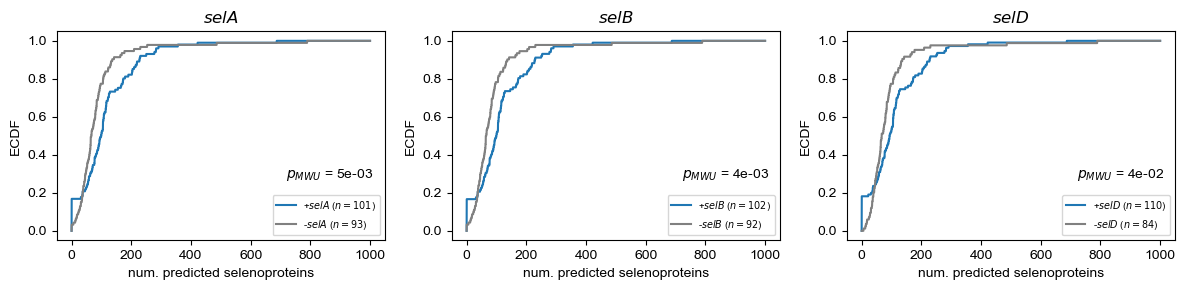

In [128]:
fig, axes = plt.subplots(figsize=(12, 3), ncols=3)

# ax.scatter(copy_numbers_df.n_hits, copy_numbers_df.sel_a_copy_number)

def plot_ecdf(values:pd.DataFrame, ax:plt.Axes=None, max_x_value:float=None, color:str='tab:blue'):
    x_vals = np.linspace(0, max_x_value, 10000)
    n = len(values)
    y_vals = [np.sum(values < x) / n for x in x_vals]
    ax.plot(x_vals, y_vals, lw=1.5, c=color)

gene_names = [r'$\it{selA}$', r'$\it{selB}$', r'$\it{selD}$']
cols = ['sel_a_copy_number', 'sel_b_copy_number', 'sel_d_copy_number']

for col, gene_name, ax in zip(cols, gene_names, axes):
    pos_df = copy_numbers_df[copy_numbers_df[col] > 0]
    neg_df = copy_numbers_df[copy_numbers_df[col] < 1]
    
    model_type = 'binary'

    plot_ecdf(pos_df[f'n_hits_{model_type}_model'], ax=ax, max_x_value=1000, color='tab:blue')
    plot_ecdf(neg_df[f'n_hits_{model_type}_model'], ax=ax, max_x_value=1000, color='gray')
    mwu_result = mannwhitneyu(pos_df[f'n_hits_{model_type}_model'], neg_df[f'n_hits_{model_type}_model'])

    ax.text(0.7, 0.3, r"$p_{MWU}$ = " + '{:.0e}'.format(mwu_result.pvalue), transform=ax.transAxes)

    ax.set_title(gene_name)
    ax.legend(['+' + gene_name + f' ($n={len(pos_df)}$)', '-' + gene_name + f' ($n={len(neg_df)}$)'], fontsize='x-small')
    ax.set_ylabel('ECDF')
    ax.set_xlabel('num. predicted selenoproteins')

plt.tight_layout()
plt.show()

# The Mann-Whitney U-test can be used to test whether there is a difference between two groups, without relying
# on the data being normally-distributed (it's a non-parametric test). Looks at the rank-sum (should probably look into this more)
# https://stats.stackexchange.com/questions/252976/mann-whitney-u-statistic-seems-very-large-is-something-wrong

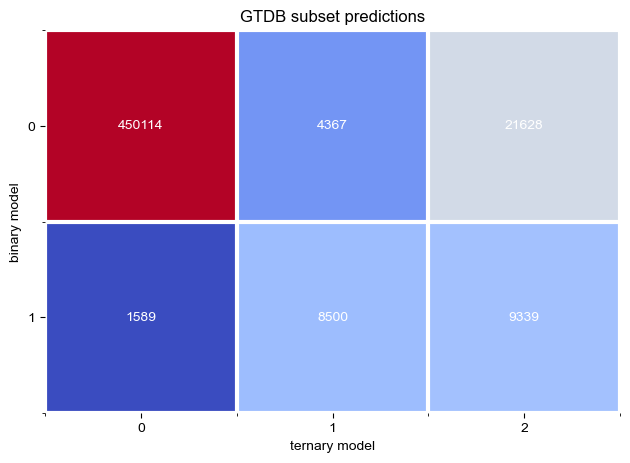

In [117]:

fig, ax = plt.subplots()
ax.set_yticks([0, 1]) # , labels=['fl', 'ts'])
ax.set_ylabel('binary model')
ax.set_xticks([0, 1, 2]) # , labels=['fl', 'ts', 'tns'])
ax.set_xlabel('ternary model')
ax.set_title('GTDB subset predictions')

data = np.zeros((2, 3))
for binary_prediction, ternary_prediction in zip(gtdb_binary_results_plm_df.prediction, gtdb_ternary_results_plm_df.prediction):
    data[binary_prediction, ternary_prediction] += 1

ax.imshow(np.log(data), cmap='coolwarm') #, norm=norm)
ax.spines[:].set_visible(False)
# NOTE: What does shifting the ticks by 0.5 to the left do? Ah it's because of where the square boundaries are. 
ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=3)

for x in range(3):
    for y in range(2):
        text = ax.text(x, y, int(data[y, x]), ha='center', va='center', color='w')

plt.tight_layout()
plt.show()

# Based on the plot below, it seems as though the ternary model has a tendency to predict full-length
# sequences to be truncated non-selenoproteins. The ternary model also has the tendency to categorize truncated selenoproteins as 
# truncated non-selenoproteins. Both generally agree on the full-length sequences. 

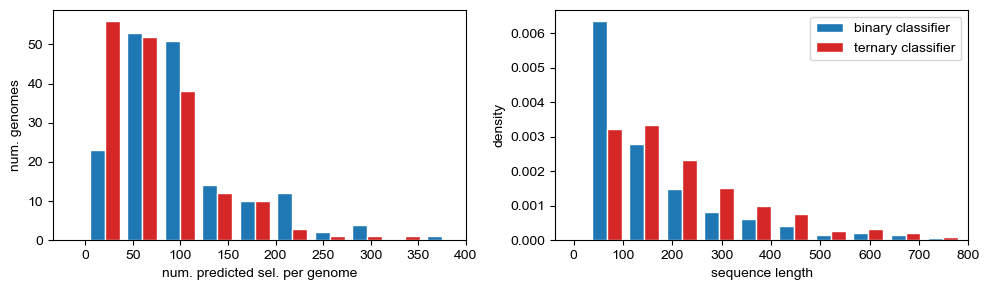

In [119]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

hits_per_genome = []
lengths = []
legend = []

for df in [gtdb_binary_results['plm'], gtdb_ternary_results['plm']]:
    hits_per_genome.append(df[df.prediction == 1].groupby('genome_id').apply(len, include_groups=False))
    lengths.append(df[df.prediction == 1].seq.apply(len))

axes[0].hist(hits_per_genome, bins=20, color=['tab:blue', 'tab:red'], edgecolor='white')
axes[0].set_xlabel('num. predicted sel. per genome')
axes[0].set_ylabel('num. genomes')

# length_distribution.append(gtdb_results['plm'].length) # Add the background length distribution. 
axes[1].hist(lengths, bins=20, density=True, color=['tab:blue', 'tab:red'], edgecolor='white')
axes[1].legend(['binary classifier', 'ternary classifier'])

axes[1].set_xlabel('sequence length')
axes[1].set_ylabel('density')
axes[1].legend(['binary classifier', 'ternary classifier'])

# This crops off some outliers... good to keep that in mind. 
axes[1].set_xlim(xmax=800)
axes[0].set_xlim(xmax=400)

plt.tight_layout()
plt.show()
# Binary classifier seems to be picking up many more of the super short sequences as truncated selenoproteins.  

In [179]:
# extended_df = pd.read_csv('../data/extend_gtdb_subset_metadata.csv', index_col=0, dtype={'partial':str})
# extended_df = extended_df.merge(binary_results_df[['prediction', 'partial'] + levels].rename(columns={'prediction':'binary_model_prediction'}), left_index=True, right_index=True)
# extended_df = extended_df.merge(ternary_results_df[['prediction']].rename(columns={'prediction':'ternary_model_prediction'}), left_index=True, right_index=True)
# assert np.all(extended_df.partial.str.match('00')), 'There are partial sequences in the DataFrame.'

# Write the extended sequences to a FASTA file to use with BLAST. 
# FASTAFile.from_df(extended_df).write('../data/extend_gtdb_subset.faa')
uniprot_sec_df = pd.read_csv('../data/uniprot_sec.csv', index_col=0)
uniprot_sec_bacteria_df = uniprot_sec_df[uniprot_sec_df.domain.str.match('Bacteria')]
uniprot_sec_archaea_df = uniprot_sec_df[uniprot_sec_df.domain.str.match('Archaea')]
# Need to ensure that there are no duplicate IDs, or BLAST can't make a database. 
assert not np.any(uniprot_sec_bacteria_df.index.duplicated()), 'There are duplicate entries in the DataFrame of bacterial selenoproteins.'
assert not np.any(uniprot_sec_archaea_df.index.duplicated()), 'There are duplicate entries in the DataFrame of archaeal selenoproteins.'

FASTAFile.from_df(uniprot_sec_bacteria_df).write('../data/uniprot_sec_bacteria.faa')
FASTAFile.from_df(uniprot_sec_archaea_df).write('../data/uniprot_sec_archaea.faa')

# blast = BLAST(cwd='../data')
# blast.run('../data/extend_gtdb_subset.faa', '../data/uniprot_sec.faa', max_high_scoring_pairs=1, make_database=True)
# blastp -query ../data/extend_gtdb_subset.faa -out ../data/extend_gtdb_subset.tsv -subject ../data/uniprot_sec.faa -max_hsps 1 -num_threads 4 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qcovs qcovhsp qlen slen'


Number of predicted full-length sequences: 471259
Number of predicted selenoproteins: 19317
99.2% of predicted full-length sequences could be extended.
98.3% of predicted selenoproteins could be extended.


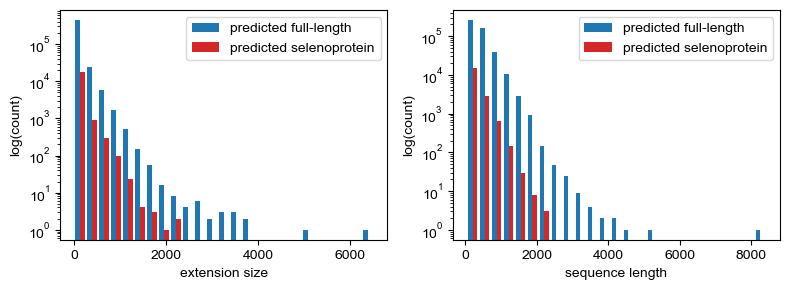

In [169]:
extended_label_0_df = extended_df[extended_df.prediction == 0]
extended_label_1_df = extended_df[extended_df.prediction == 1]
print(f'{100 * (extended_label_0_df.extension_size > 0).sum() / len(extended_label_0_df):.1f}% of predicted full-length sequences could be extended.')
print(f'{100 * (extended_label_1_df.extension_size > 0).sum() / len(extended_label_1_df):.1f}% of predicted selenoproteins could be extended.')
extended_label_0_df = extended_label_0_df[extended_label_0_df.extension_size > 0]
extended_label_1_df = extended_label_1_df[extended_label_1_df.extension_size > 0]

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

axes[0].hist((extended_label_0_df.extension_size / 3, extended_label_1_df.extension_size / 3), bins=25, color=['tab:blue', 'tab:red']) #, density=True)
axes[0].legend(['predicted full-length', 'predicted selenoprotein'])
axes[0].set_yscale('log')
axes[0].set_ylabel('log(count)')
axes[0].set_xlabel('extension size')

axes[1].hist((extended_label_0_df.seq.apply(len), extended_label_1_df.seq.apply(len)), bins=25, color=['tab:blue', 'tab:red'])
axes[1].legend(['predicted full-length', 'predicted selenoprotein'])
axes[1].set_yscale('log')
axes[1].set_ylabel('log(count)')
axes[1].set_xlabel('sequence length')

plt.tight_layout()
plt.show()

In [ ]:
# metadata_subset_df = pd.read_csv('../data/gtdb_subset_metadata.csv').rename(columns={'ncbi_taxid':'ncbi_taxonomy_id'})
# # Quantify potential leakage between the GTDB data and the training, testing, and validation datasets. 
# levels = ['phylum', 'class', 'order', 'genus', 'species', 'family', 'domain']
# train_metadata_df = pd.read_csv('../data/train_metadata.csv', index_col=0) 
# test_metadata_df = pd.read_csv('../data/test_metadata.csv', index_col=0) 
# val_metadata_df = pd.read_csv('../data/val_metadata.csv', index_col=0)

# train_ncbi_taxonomy_ids = train_metadata_df.ncbi_taxonomy_id.unique()
# test_ncbi_taxonomy_ids = test_metadata_df.ncbi_taxonomy_id.unique()
# val_ncbi_taxonomy_ids = val_metadata_df.ncbi_taxonomy_id.unique()

# train_overlapping_taxonomy_ids = np.intersect1d(metadata_subset_df.ncbi_taxonomy_id.values, train_ncbi_taxonomy_ids)
# test_overlapping_taxonomy_ids = np.intersect1d(metadata_subset_df.ncbi_taxonomy_id.values, test_ncbi_taxonomy_ids)
# val_overlapping_taxonomy_ids = np.intersect1d(metadata_subset_df.ncbi_taxonomy_id.values, val_ncbi_taxonomy_ids)

# overlapping_taxonomy_ids = np.unique(np.concat([train_overlapping_taxonomy_ids, val_overlapping_taxonomy_ids, test_overlapping_taxonomy_ids]))

# print(len(train_overlapping_taxonomy_ids), f'overlapping taxa in the training dataset (total {len(train_ncbi_taxonomy_ids)}).')
# print(len(test_overlapping_taxonomy_ids), f'overlapping taxa in the testing dataset (total {len(test_ncbi_taxonomy_ids)}).')
# print(len(val_overlapping_taxonomy_ids), f'overlapping taxa in the validation dataset (total {len(val_ncbi_taxonomy_ids)}).')